In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
import itertools

import stateinterpreter.MD 

is_reload = False

In [3]:
if is_reload:
    from importlib import reload
    reload(stateinterpreter)
    reload(stateinterpreter.MD)
    reload(stateinterpreter.classifier)

## Loader

In [4]:
from stateinterpreter.MD import Loader

data_folder = "data/chignolin-v3/"

file_dict = {
    'trajectory': 'CLN025-0-protein-ALL.dcd',
    'topology' : 'CLN025-0-protein.pdb',
    'collective_vars': 'COLVAR'
}
stride = 10
data = Loader(data_folder, file_dict, stride=stride,_DEV=False)

# Rename TICA CVs
data.colvar = data.colvar.rename(columns={'deep.node-4': 'tica1','deep.node-3': 'tica2','deep.node-2': 'tica3', 'deep.node-1': 'tica4','deep.node-0': 'tica5'})

## Define states based on FES minima

In [25]:
# Collective variables used for classes identification
collective_vars = ['tica1', 'tica2'] #, 'tica3']
bounds = [(-1.1,1.1)]*len(collective_vars)

# Identify basins and compute descriptors
colvar = data.load(collective_vars, bounds, num=50, memory_saver=False, )

# Define folder for basins identification (save dataframe and plots)
states_folder = 'results/chignolin-unbiased/tica-2d/'
!mkdir -p {states_folder}

# save dataframe
colvar.to_csv(states_folder+'dataframe',sep=' ')

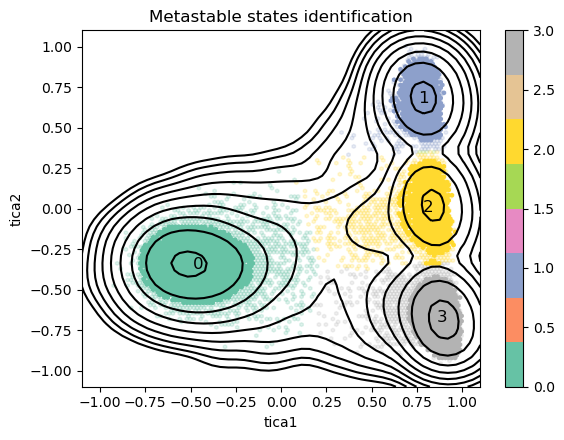

In [26]:
basins = colvar['basin'].unique()

def compute_basin_mean(df, basin, label_x, label_y):
    mx = df[df['basin'] == basin][label_x].mean()
    my = df[df['basin'] == basin][label_y].mean()
    return mx,my
    
# scatter plot of tica components 
pairs = [['tica1','tica2']]# ,['tica1','tica3'],['tica2','tica3']]

fig, axs = plt.subplots(1,len(pairs),figsize=(6*len(pairs),4.5),dpi=100)
for k,(label_x,label_y) in enumerate(pairs):
    # select ax
    ax = axs[k] if len(pairs) > 1 else axs

    # FES isolines (if 2D)
    if data.FES[1].ndim == 2:
        sampled_positions, f = data.FES

        xx = sampled_positions[0]
        yy = sampled_positions[1]
        cset = ax.contour(xx, yy, f, levels=np.linspace(1,30,10), colors='k')

    # hexbin plot
    colvar.plot.hexbin(label_x,label_y,C='basin',cmap='Set2',ax=ax,alpha=0.2,colorbar=False)
    pp = colvar[colvar['selection']].plot.hexbin(label_x,label_y,C='basin',cmap='Set2',ax=ax)
    ax.set_title('Metastable states identification')

    #add basins labels
    for b in basins:
        mx,my = compute_basin_mean(colvar,b,label_x,label_y)
        text = ax.text(mx, my, b, ha="center", va="center", 
                       color="k", fontsize='large')

plt.savefig(states_folder+'states.png',bbox_inches='tight')
plt.tight_layout()

## State interpreter

In [32]:
from stateinterpreter.classifier import MD_Data, CV_path

states_folder = 'results/chignolin-unbiased/tica-2d/'

colvar = pd.read_csv(states_folder+'dataframe', sep=' ')
model = MD_Data(colvar)

# input features
select_feat = 'HB_CONTACT|sin_|cos_'
sample = model.sample(1000, regex_filter = select_feat)

# Define results folder (save plots and results)
save_results = True
results_folder = states_folder + 'angles-hbonds/'
!mkdir -p {results_folder}

### Functions 

TODO --> move them to package?

In [25]:
# plot cvpath and print info about features
def get_relevant_features(cvpath, C, save_results, results_folder, base_prefix='linear'):

    print('\n-- RELEVANT FEATURES --')
    # print features per state
    cvpath.print_relevant_features(C)

    # unique features
    relevant_feat = cvpath.relevant_features(C)

    unique_features = set()
    for state in relevant_feat.values():
        for feat in state:
            unique_features.add(feat[1])
    unique_features = list(unique_features)

    #sort based on residue #TODO this works only for angles, generalize or change features names
    #unique_features.sort(key=lambda x: int(x[-1]))

    print('\n-- UNIQUE FEATURES --')
    for feat in unique_features:
        print(feat)

    # save to file
    if save_results:
        with open(results_folder+base_prefix+'-features.txt', 'w') as f:
            print('\n-- RELEVANT FEATURES --',file=f)
            cvpath.print_relevant_features(C,file=f)
            print('\n-- UNIQUE FEATURES --',file=f)
            for feat in unique_features:
                print(feat,file=f)

    return relevant_feat, unique_features

In [8]:
# aux function to compute basins mean
def compute_basin_mean(df, basin, label_x, label_y):
    mx = df[df['basin'] == basin][label_x].mean()
    my = df[df['basin'] == basin][label_y].mean()
    return mx,my

# color CVs space by TICA
def plot_CVs_space(colvar, relevant_feat, max_nfeat = 3):

    # retrieve basins
    basins = colvar['basin'].unique()
    n_basins = len(basins)

    # scatter plot of tica components 
    pairs = [['tica1','tica2']]
    label_x,label_y = pairs[0]

    fig, axs = plt.subplots(n_basins,max_nfeat,figsize=(6 * max_nfeat, 5* n_basins),dpi=100, )
                            #sharex=True, sharey=True)

    # for each state ...
    for i,(state,feat_list) in enumerate(relevant_feat.items()):
        # ... color with the corresponding features ...
        for j,feat_array in enumerate(feat_list):
            # ... up to max_nfeat plot per state
            if j < max_nfeat:
                feat = feat_array[1]
                importance = feat_array[2]
                ax = axs[i,j]
                pp = colvar[colvar['selection']==1].plot.hexbin(label_x,label_y,C=feat,cmap='coolwarm',ax=ax)
                #set title
                ax.set_title(f'[state {state}] {feat} - {np.round(importance*100)}%')
                #add basins labels
                for b in basins:
                    mx,my = compute_basin_mean(colvar,b,label_x,label_y)
                    bcolor = 'k' if b == i else 'w'
                    fcolor = 'w' if b == i else 'k'            
                    ax.scatter(mx,my,color=bcolor,s=250,alpha=0.7)
                    text = ax.text(mx, my, b, ha="center", va="center", 
                                color=fcolor, fontsize='large')
        
        #set labels
        for ax in plt.gcf().axes:
            try:
                ax.label_outer()
            except:
                pass

        #disable unused axis
        for j in range(len(feat_list),max_nfeat):
            axs[i,j].axis('off')

    plt.tight_layout()

### Linear kernel

In [33]:
C_range = np.geomspace(2, 100, 25)
kwargs = {'LASSO':True, 'max_iter':1000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: Conver

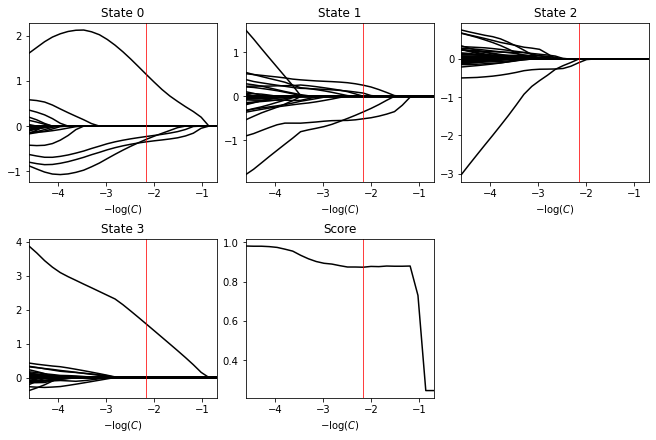


-- RELEVANT FEATURES --
State 0:
	 83.4%  | SIDECHAIN cos_chi1 ASP3
	 7.7%   | HB_CONTACT TYR1-O -- TYR10-N
	 5.5%   | HB_CONTACT ASP3-O -- GLY7-N
	 3.4%   | HB_CONTACT ASP3-N -- THR8-O
State 1:
	 57.2%  | SIDECHAIN cos_chi1 THR8
	 27.6%  | SIDECHAIN sin_chi1 THR6
	 14.0%  | HB_CONTACT THR8-OG1s -- TRP9-O
	 1.2%   | HB_CONTACT TYR2-OHs -- THR8-N
	 0.0%   | HB_CONTACT ASP3-N -- TYR10-N
State 2:
	 100.0% | SIDECHAIN cos_chi1 ASP3
State 3:
	 100.0% | HB_CONTACT THR6-OG1s -- THR8-OG1s

-- UNIQUE FEATURES --
SIDECHAIN sin_chi1 THR6
HB_CONTACT TYR1-O -- TYR10-N
SIDECHAIN cos_chi1 ASP3
HB_CONTACT TYR2-OHs -- THR8-N
HB_CONTACT THR6-OG1s -- THR8-OG1s
SIDECHAIN cos_chi1 THR8
HB_CONTACT ASP3-O -- GLY7-N
HB_CONTACT THR8-OG1s -- TRP9-O
HB_CONTACT ASP3-N -- THR8-O
HB_CONTACT ASP3-N -- TYR10-N


In [34]:
C = np.exp(2.1)

# PLOT
base_prefix = 'linear'
cvpath.plot(C)
if save_results:
    plt.savefig(results_folder+base_prefix+'-cvpath.png',
            facecolor='w', 
            transparent=False,
            bbox_inches='tight')
plt.show()

# RELEVANT FEATURES
relevant_feat, unique_features = get_relevant_features(cvpath,C,save_results,results_folder,base_prefix=base_prefix)

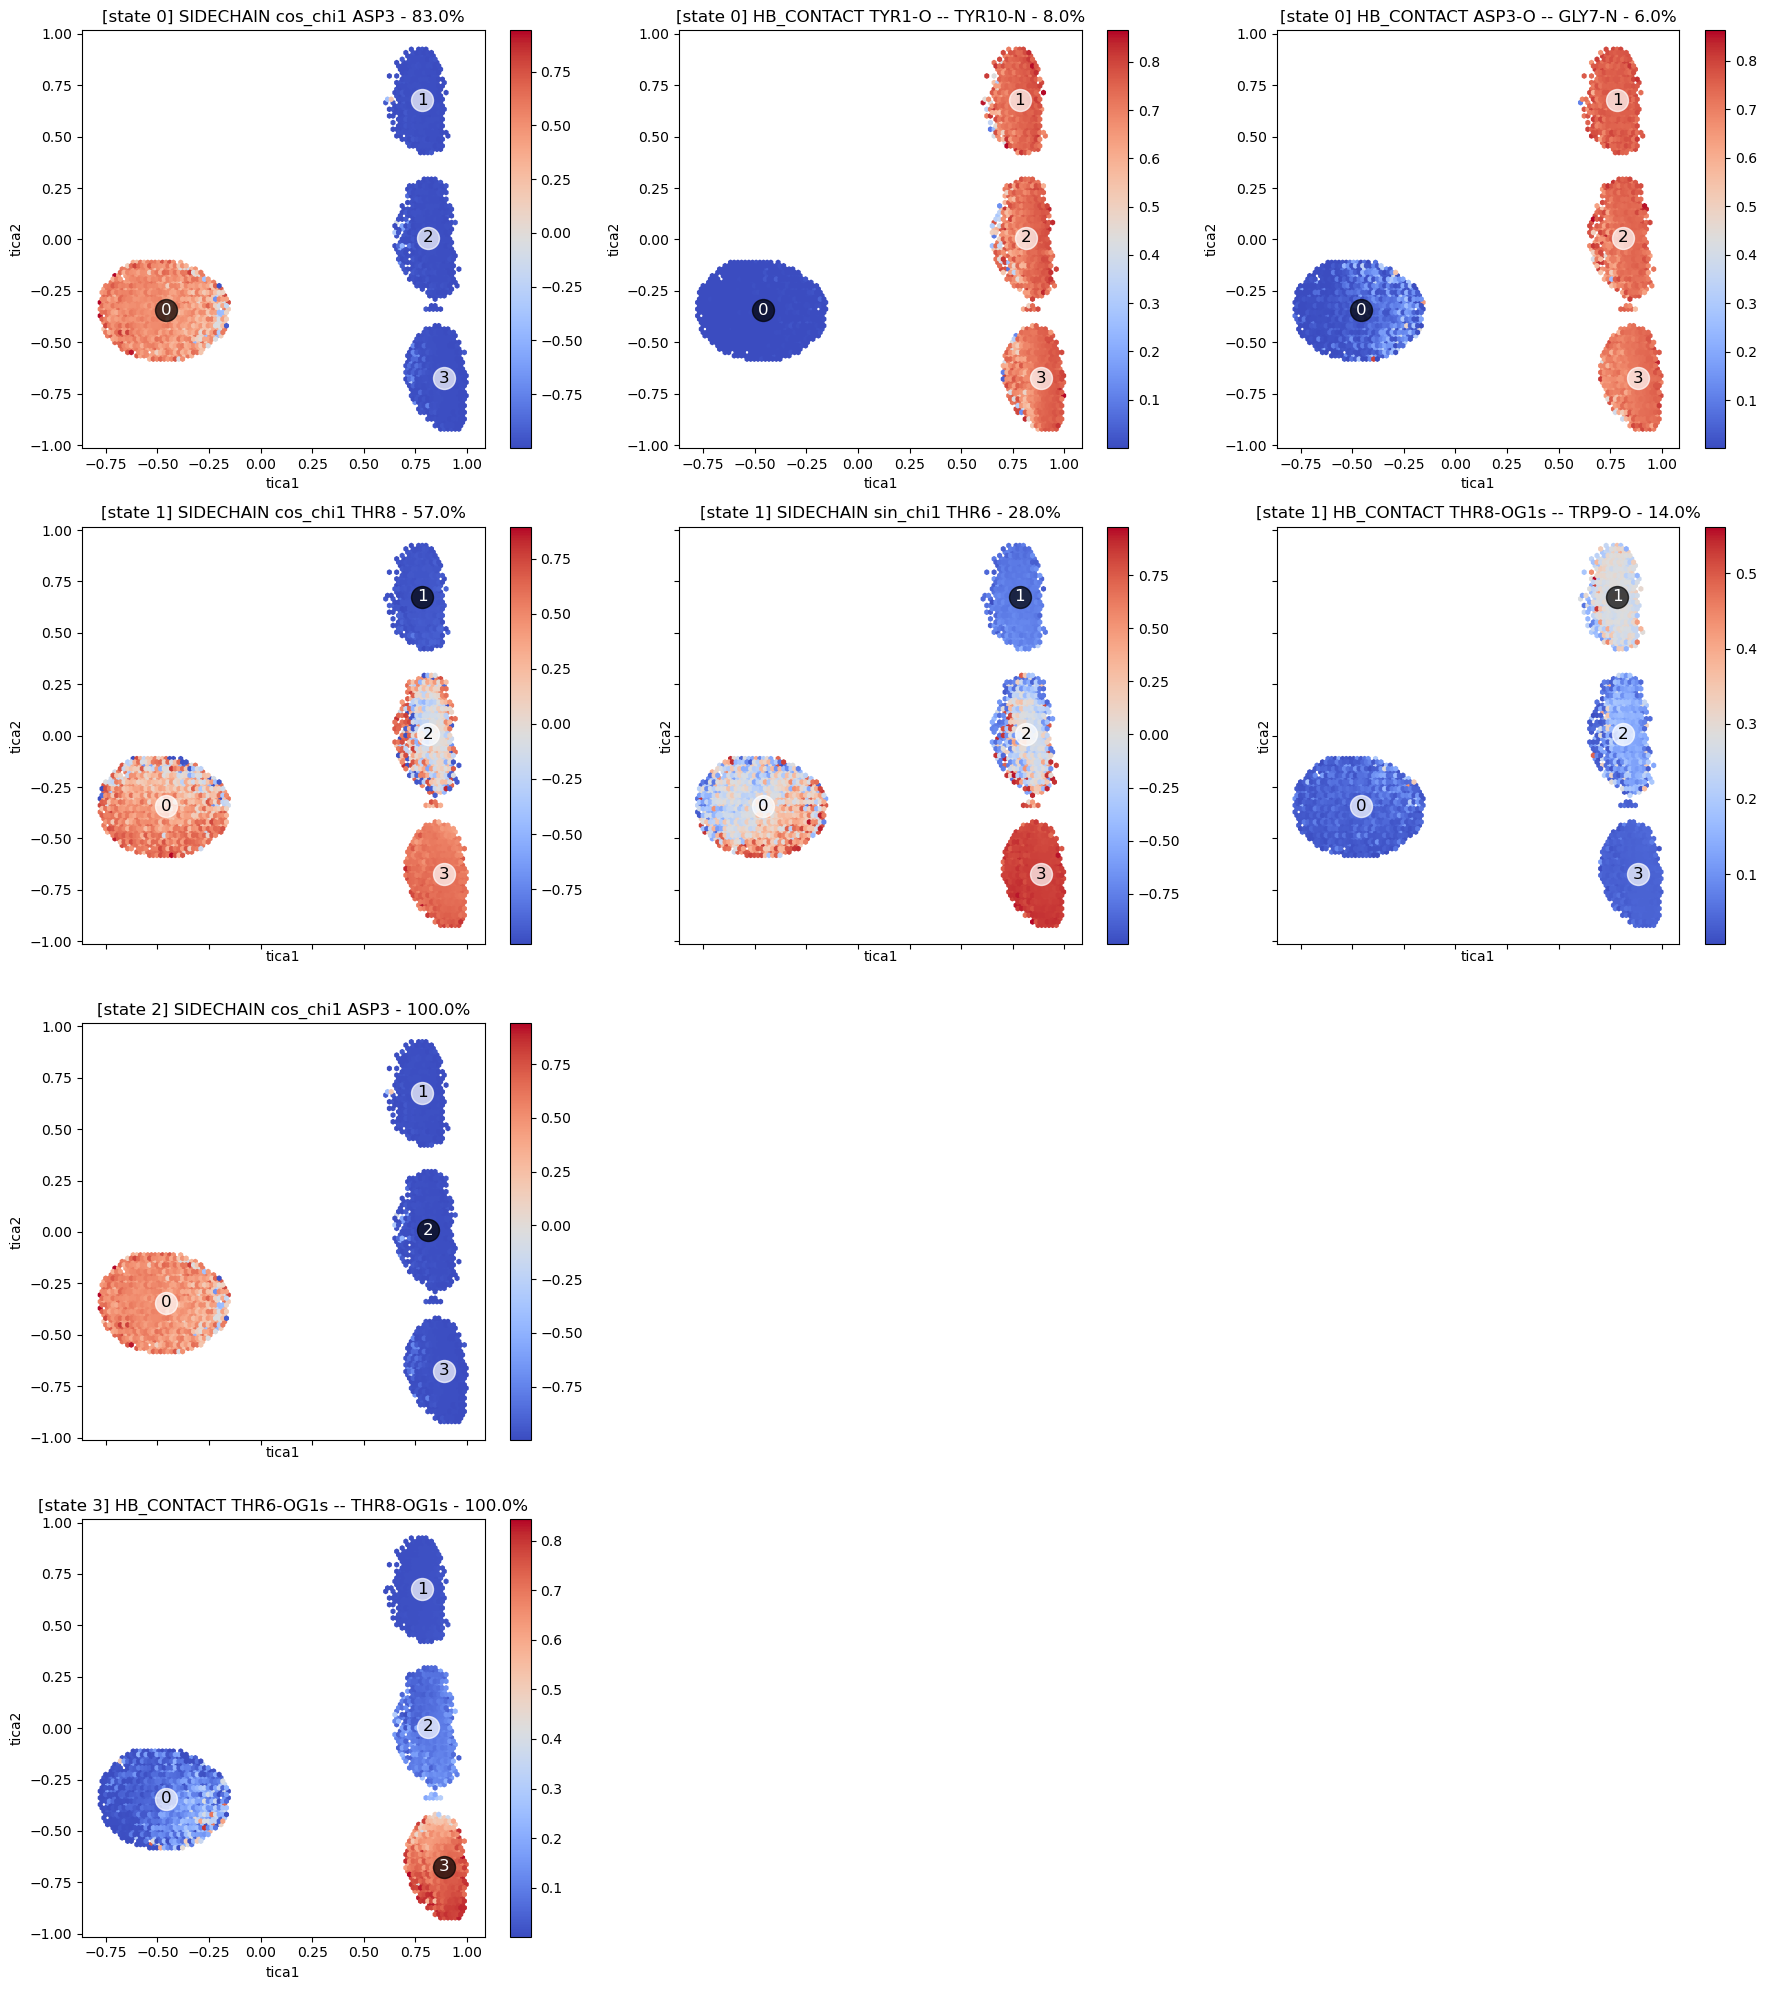

In [35]:
# PLOT FEATURES vs TICAs

plot_CVs_space(colvar, relevant_feat, max_nfeat = 3)

if save_results:
    plt.savefig(results_folder+base_prefix+'-relevant_feats.png',
                facecolor='w', 
                transparent=False,
                bbox_inches='tight')
plt.show()

In [ ]:
# DEPRECATED, see cell above for plotting

basins = colvar['basin'].unique()

# scatter plot of tica components 
pairs = [['tica1','tica2']]#,['tica1','tica3'],['tica2','tica3']]

for feat in unique_features:
    fig, axs = plt.subplots(1,len(pairs),figsize=(6*len(pairs),4.5),dpi=100)
    for k,(label_x,label_y) in enumerate(pairs):
        ax = axs[k] if len(pairs) > 1 else axs
        pp = colvar[colvar['selection']==1].plot.hexbin(label_x,label_y,C=feat,cmap='coolwarm',ax=ax)
        ax.set_title(feat)
        #add basins labels
        for b in basins:
            mx,my = compute_basin_mean(colvar,b,label_x,label_y)
            text = ax.text(mx, my, b, ha="center", va="center", 
                        color="w", fontsize='large')
    plt.tight_layout()

### Quadratic kernel

In [36]:
# Quadratic Kernel

prunedcv = cvpath.get_pruned_CVpath(C)
prunedcv.compute(C_range_in, **kwargs);


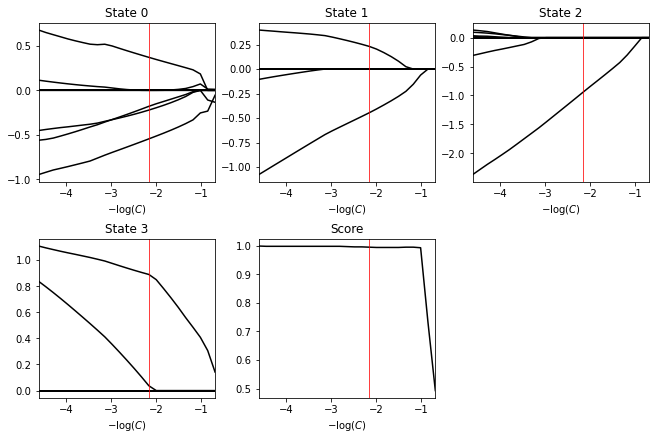


-- RELEVANT FEATURES --
State 0:
	 57.5% | HB_CONTACT TYR1-O -- TYR10-N
	 26.8% | SIDECHAIN cos_chi1 ASP3
	 9.5%  | HB_CONTACT ASP3-O -- GLY7-N
	 6.2%  | HB_CONTACT ASP3-N -- THR8-O
	 0.0%  | HB_CONTACT TYR1-O -- TYR10-N || HB_CONTACT ASP3-N -- THR8-O
State 1:
	 78.8% | SIDECHAIN cos_chi1 THR8
	 21.2% | SIDECHAIN sin_chi1 THR6 || SIDECHAIN cos_chi1 THR8
State 2:
	 100.0% | SIDECHAIN sin_chi1 THR6 || SIDECHAIN cos_chi1 THR8
State 3:
	 99.8% | HB_CONTACT THR6-OG1s -- THR8-OG1s
	 0.2%  | SIDECHAIN sin_chi1 THR6

-- UNIQUE FEATURES --
SIDECHAIN sin_chi1 THR6 || SIDECHAIN cos_chi1 THR8
SIDECHAIN cos_chi1 ASP3
HB_CONTACT TYR1-O -- TYR10-N
HB_CONTACT THR6-OG1s -- THR8-OG1s
SIDECHAIN sin_chi1 THR6
SIDECHAIN cos_chi1 THR8
HB_CONTACT ASP3-O -- GLY7-N
HB_CONTACT TYR1-O -- TYR10-N || HB_CONTACT ASP3-N -- THR8-O
HB_CONTACT ASP3-N -- THR8-O


In [37]:
C = np.exp(2.1)

# PLOT
base_prefix = 'pruned'
prunedcv.plot(C)
if save_results:
    plt.savefig(results_folder+base_prefix+'-cvpath.png',
            facecolor='w', 
            transparent=False,
            bbox_inches='tight')
plt.show()

# RELEVANT FEATURES
relevant_feat, unique_features = get_relevant_features(prunedcv,C,save_results,results_folder,base_prefix=base_prefix)

In [38]:
# add quadratic features to colvar
for feat in unique_features:
    if "||" in feat:
        if feat not in colvar.columns: 
            i, j = feat.split(' || ')
            feat_ij = colvar[i].values * colvar[j].values
            colvar[feat] = feat_ij

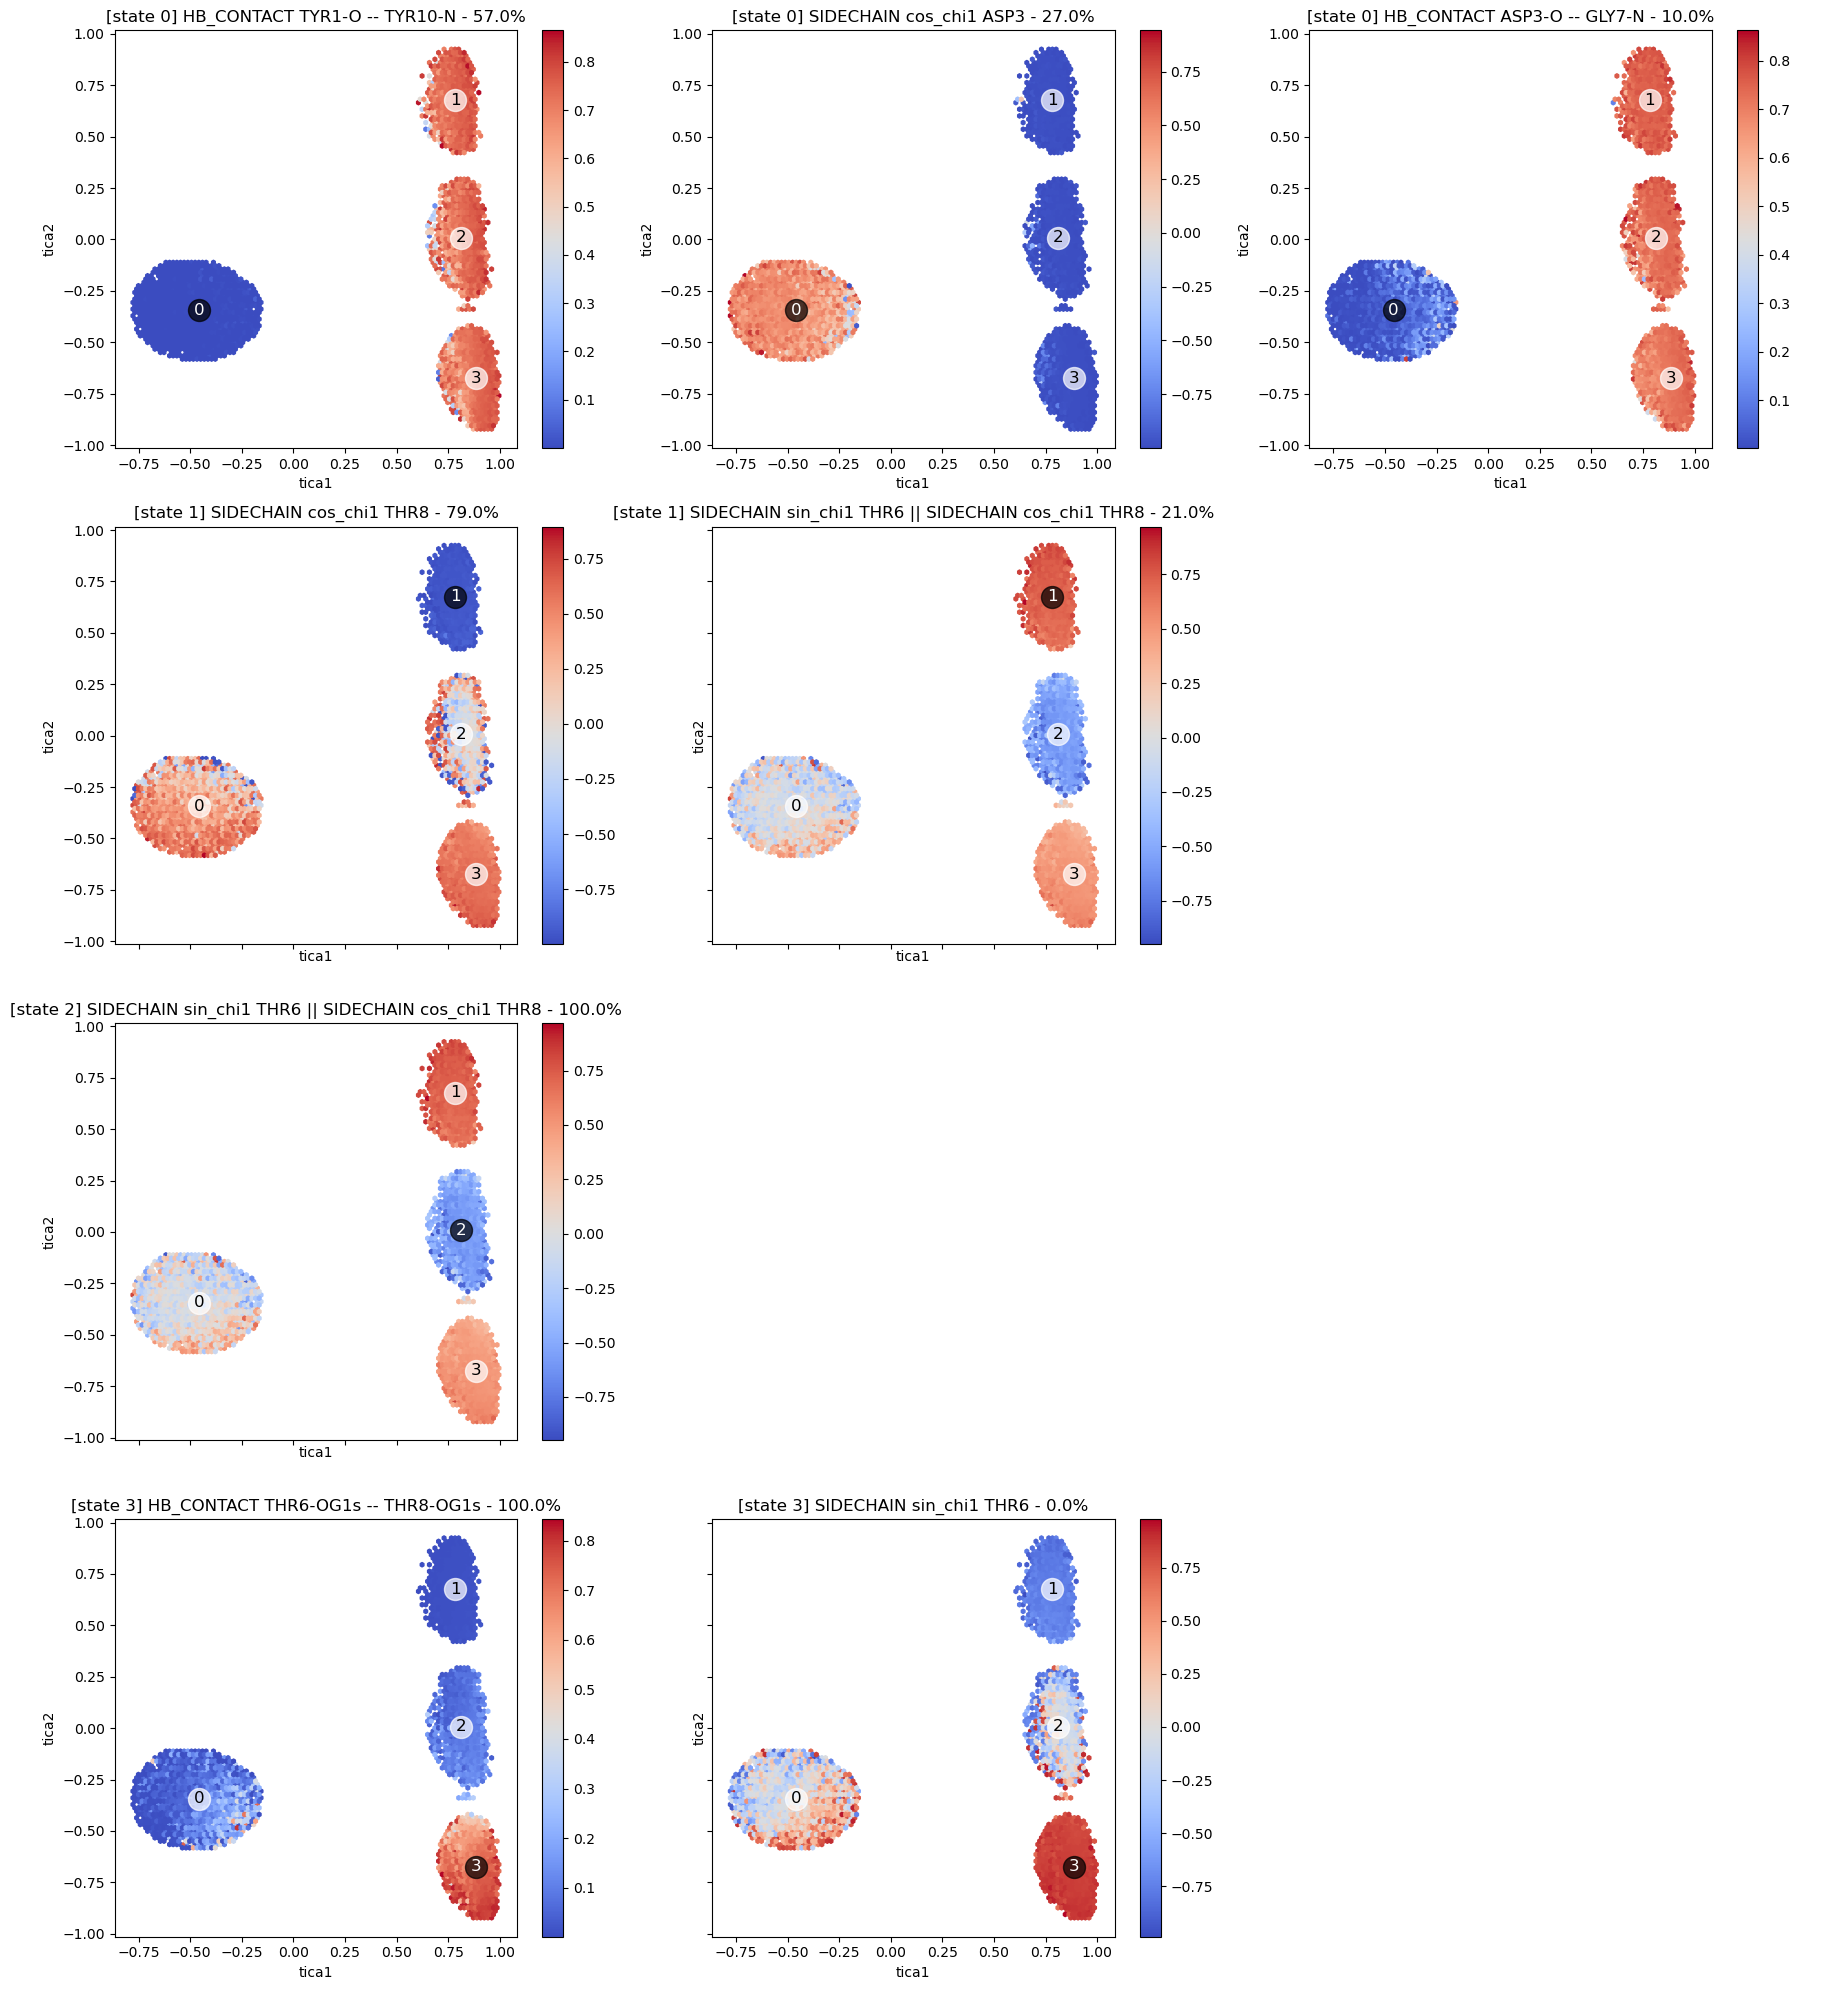

In [39]:
# PLOT FEATURES vs TICAs

plot_CVs_space(colvar, relevant_feat, max_nfeat = 3)

if save_results:
    plt.savefig(results_folder+base_prefix+'-relevant_feats.png',
                facecolor='w', 
                transparent=False,
                bbox_inches='tight')
plt.show()

## (visualize protein)

In [23]:
import nglview

traj_file = data_folder + 'CLN025-0-protein-ALL.dcd'
topo_file = data_folder + 'CLN025-0-protein.pdb'
ref_file = data_folder + 'chignolin-ref-ca-DES.pdb'

traj = md.load(traj_file, top=topo_file,stride=stride)
ref = md.load(ref_file)

# superimpose to ref
traj.superpose(ref)

# set up visualization
view = nglview.show_mdtraj(traj)
view.clear_representations()
view.add_licorice('(not hydrogen)',opacity=0.35)
view.add_licorice('(backbone) and (not hydrogen)')
selection = '(6 8)'
view.add_licorice(selection+' and (not hydrogen)')
view.add_ball_and_stick(selection+' and (not hydrogen)',color='yellow',opacity=0.75)

view

NGLWidget(max_frame=52474)